In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import zipfile
# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/data/sub.zip","r")
# zip_ref.extractall("/content")
# zip_ref.close()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import os
import glob
import tifffile
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.models import load_model
#from tensorflow.keras.layers.experimental.preprocessing import ToTensor
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,BatchNormalization, Dropout, Conv2DTranspose, concatenate, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import sys
from keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# ROOT_DIR ="../sub/38-Cloud_train"

In [6]:
# splitfolders.ratio(ROOT_DIR,output="splited_data",
#                    seed=42,
#                    ratio=(.9,.1,.0),
#                    group_prefix=None)

In [7]:
class CloudTestDataset(tf.keras.utils.Sequence):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir):
        self.r_dir = r_dir
        self.g_dir = g_dir
        self.b_dir = b_dir
        self.nir_dir = nir_dir
        self.files = [self.combine_files(f) for f in self.r_dir.iterdir() if not f.is_dir()]

    def combine_files(self, r_file):
        files = {'red': r_file,
                 'green': self.g_dir / r_file.name.replace('red', 'green'),
                 'blue': self.b_dir / r_file.name.replace('red', 'blue'),
                 'nir': self.nir_dir / r_file.name.replace('red', 'nir')}
        return files

    def __len__(self):
        return len(self.files)

    def open_as_array(self, idx, invert=False, include_nir=False):
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)

        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)

        if invert:
            raw_rgb = np.transpose(raw_rgb, (2, 0, 1))

        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)

    def __getitem__(self, idx):
        x = tf.constant(self.open_as_array(idx, invert=False, include_nir=True), dtype=tf.float32)

        return x

    def take(self, count):
        return [self[idx] for idx in range(count)]

    def skip(self, count):
        return [self[idx] for idx in range(count, len(self.files))]

    def generator(self):
        for idx in range(len(self.files)):
            x = self.open_as_array(idx, invert=False, include_nir=True)
            yield x

    def create_tf_dataset(self):
        return tf.data.Dataset.from_generator(
            self.generator,
            output_signature=tf.TensorSpec(shape=x.shape, dtype=tf.float32)
        )

# Replace these paths with the actual paths to your dataset directories
base_test_path = Path('../sub/38-Cloud_test')
test_r_dir = base_test_path / 'test_red'
test_g_dir = base_test_path / 'test_green'
test_b_dir = base_test_path / 'test_blue'
test_nir_dir = base_test_path / 'test_nir'

# Create an instance of your custom TensorFlow test dataset
test_dataset = CloudTestDataset(r_dir=test_r_dir, g_dir=test_g_dir, b_dir=test_b_dir, nir_dir=test_nir_dir)

print(f'length--> {len(test_dataset)}')

# Example usage
for batch in test_dataset:
    x = batch
    print("Shape of input data (x):", x.shape)
    break

length--> 3579
Shape of input data (x): (384, 384, 4)


In [11]:
class CloudDataset(tf.keras.utils.Sequence):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, augmentation=False, num_augmentations=1):
        self.r_dir = r_dir
        self.g_dir = g_dir
        self.b_dir = b_dir
        self.nir_dir = nir_dir
        self.gt_dir = gt_dir
        self.augmentation = augmentation
        self.num_augmentations = num_augmentations
        self.files = []
        self.image_data_generator = self.create_data_generator()

        # Combine files and augment if needed
        self.unique_augmented_files = set()

        for f in self.r_dir.iterdir():
            if not f.is_dir():
                original_files = self.combine_files(f)

                # Augment the original image and store unique augmented files
                for _ in range(self.num_augmentations + 1):
                    augmented_files = self.augment_files(original_files)

                    # Get unique identifier for the original files
                    original_identifier = self.get_augmented_identifier(original_files)

                    # Check if augmented files are unique before appending
                    if original_identifier not in self.unique_augmented_files:
                        self.files.append(augmented_files)
                        self.unique_augmented_files.add(original_identifier)

    def get_augmented_identifier(self, original_files):
        # Customize this function based on your needs
        # You can concatenate relevant paths or use any logic to create a unique identifier
        identifier = f"{original_files['red']}_{original_files['green']}_{original_files['blue']}"
        return identifier

    def create_data_generator(self):
        return ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='reflect'
        )

    def combine_files(self, r_file):
        files = {'red': r_file,
                 'green': self.g_dir / r_file.name.replace('red', 'green'),
                 'blue': self.b_dir / r_file.name.replace('red', 'blue'),
                 'nir': self.nir_dir / r_file.name.replace('red', 'nir'),
                 'gt': self.gt_dir / r_file.name.replace('red', 'gt')}
        return files

    def __len__(self):
        return len(self.files) * (self.num_augmentations + 1)

    def load_image(self, file):
        if isinstance(file, np.ndarray):
            return file
        return np.array(Image.open(str(file)))

    def augment_files(self, files):
        seed = np.random.randint(0, 1000)

        # Combine all channels into a single 4D array
        all_channels = np.stack([self.load_image(files[key]) for key in files], axis=-1)

        # Apply augmentation to the 4D array
        augmented_all_channels = self.image_data_generator.random_transform(all_channels, seed=seed)

        # Split the augmented array back into individual channels
        augmented_files = {key: augmented_all_channels[..., i] for i, key in enumerate(files.keys())}

        return augmented_files

    def __getitem__(self, idx):
        real_idx = idx // (self.num_augmentations + 1)  # Calculate the index for real images
        aug_idx = idx % (self.num_augmentations + 1)  # Calculate the index for augmented images

        file_paths = self.files[real_idx]

        # Load real images using updated open_as_array and open_mask methods
        real_x = self.open_as_array(file_paths, include_nir=True)
        real_y = self.open_mask(file_paths)

        if aug_idx > 0 and self.augmentation:
            # Augment the real image and mask
            real_x, real_y = self.augment_data(real_x, real_y)

        return real_x, real_y

    def open_as_array(self, file_paths, include_nir=False):
        # Load image data from file paths
        image_data = {key: self.load_image(file_paths[key]) for key in file_paths}

        # Extract the individual arrays from the dictionary
        channels = ['red', 'green', 'blue', 'nir'] if include_nir else ['red', 'green', 'blue']
        image_array = np.stack([image_data[key] for key in channels], axis=-1)

        # Normalize the image array for augmented images
        image_array = image_array / 255.0  # Assuming pixel values are in the range [0, 255]

        return image_array

    def open_mask(self, file_paths):
        if isinstance(file_paths['gt'], str):  # Check if it's a file path
            raw_mask = np.array(Image.open(file_paths['gt']))
        else:  # Assume it's a NumPy array
            raw_mask = file_paths['gt']

        raw_mask = np.where(raw_mask == 255, 1, 0)
        return np.expand_dims(raw_mask, -1)  # Ensure 2D tensor


     
    def augment_data(self, x, y):
        seed = np.random.randint(0, 1000)
        # Augment the real image and mask
        x_augmented = self.image_data_generator.random_transform(x, seed=seed)
        y_augmented = self.image_data_generator.random_transform(y, seed=seed)

        # Ensure that the data types are consistent
        x_augmented = x_augmented.astype(x.dtype)
        y_augmented = y_augmented.astype(y.dtype)

        return x_augmented, y_augmented

    def generator(self):
        for idx in range(len(self.files)):
            file_paths = self.files[idx]
            real_x = self.open_as_array(file_paths, include_nir=True)
            real_y = self.open_mask(file_paths)

            for aug_idx in range(self.num_augmentations + 1):
                if aug_idx > 0 and self.augmentation:
                    x_augmented, y_augmented = self.augment_data(real_x, real_y)
                    yield {'image': x_augmented}, {'mask': y_augmented}
                else:
                    yield {'image': real_x}, {'mask': real_y}

    def create_tf_dataset(self):
        dataset = tf.data.Dataset.from_generator(
            self.generator,
            output_signature=(
                {'image': tf.TensorSpec(shape=(None, None, 4), dtype=tf.float32)},
                {'mask': tf.TensorSpec(shape=(None, None, 1), dtype=tf.float32)}
            )
        )
        return dataset
    
# Example usage for the training dataset with augmentation
base_path_train = Path('./splited_data/train')
r_dir_train = base_path_train / 'train_red'
g_dir_train = base_path_train / 'train_green'
b_dir_train = base_path_train / 'train_blue'
nir_dir_train = base_path_train / 'train_nir'
gt_dir_train = base_path_train / 'train_gt'

num_aug = 2
augmentation=True
train_dataset_augmented = CloudDataset(r_dir=r_dir_train, g_dir=g_dir_train, b_dir=b_dir_train, nir_dir=nir_dir_train, gt_dir=gt_dir_train, augmentation=augmentation, num_augmentations=num_aug)
print(f'Training dataset length: {train_dataset_augmented.__len__()}')

# Example usage for the training dataset with augmentation
base_path_train = Path('./splited_data/val')
r_dir_train = base_path_train / 'train_red'
g_dir_train = base_path_train / 'train_green'
b_dir_train = base_path_train / 'train_blue'
nir_dir_train = base_path_train / 'train_nir'
gt_dir_train = base_path_train / 'train_gt'


val_dataset_augmented = CloudDataset(r_dir=r_dir_train, g_dir=g_dir_train, b_dir=b_dir_train, nir_dir=nir_dir_train, gt_dir=gt_dir_train, augmentation=augmentation, num_augmentations=num_aug)
print(f'Training dataset length: {val_dataset_augmented.__len__()}')

Training dataset length: 12279
Training dataset length: 1362


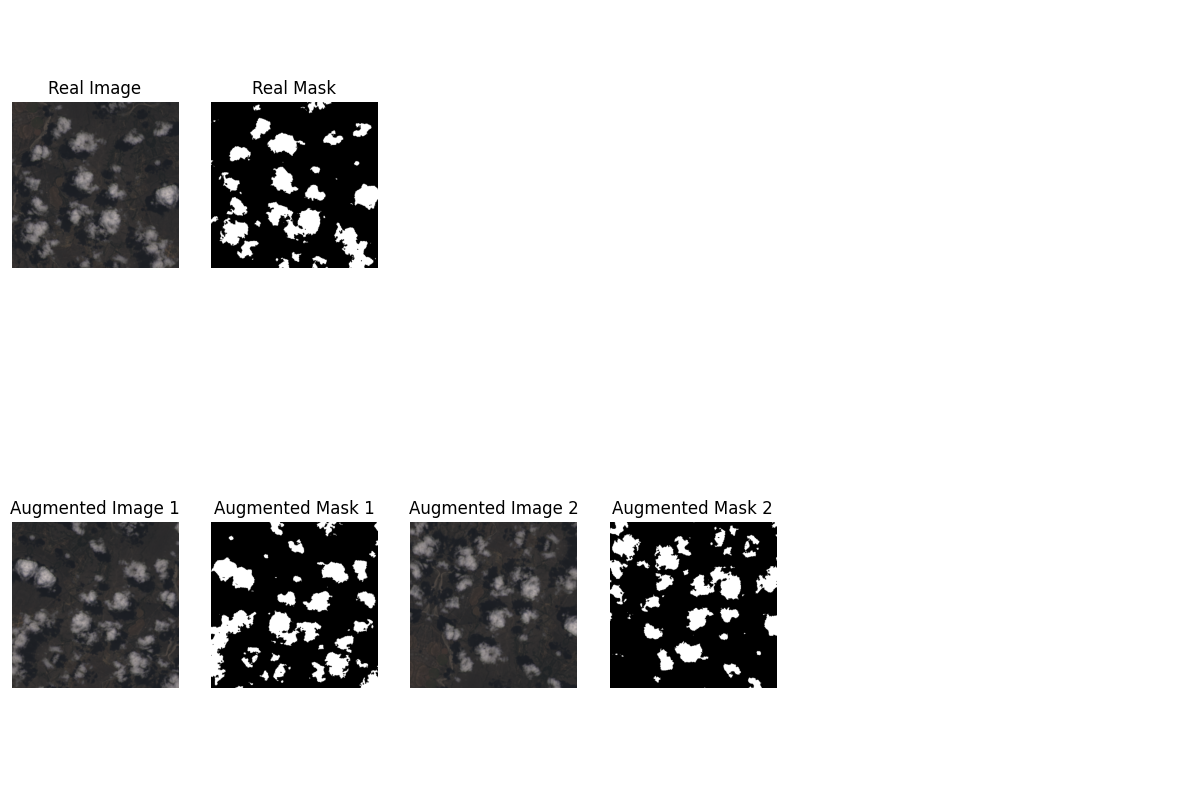

In [13]:
# Example usage for visualization
sample_idx = 3
real_image, real_mask = train_dataset_augmented.__getitem__(sample_idx)

# Augmented images for visualization
augmented_images = []
augmented_masks = []
for i in range(1, train_dataset_augmented.num_augmentations + 1):
    augmented_image, augmented_mask = train_dataset_augmented.__getitem__(sample_idx + i)
    augmented_images.append(augmented_image)
    augmented_masks.append(augmented_mask)

# Display the images and masks based on num_augmentations
num_augmentations = train_dataset_augmented.num_augmentations

fig, axes = plt.subplots(2, 2 * (num_augmentations + 1), figsize=(15, 10))

# Display the real image and mask
axes[0, 0].imshow(real_image[:, :, :3]/255.0)  # Display only RGB channels
axes[0, 0].set_title('Real Image')
axes[0, 1].imshow(np.squeeze(real_mask), cmap='gray')
axes[0, 1].set_title('Real Mask')

# Display the augmented images and masks
for i in range(num_augmentations):
    axes[1, 2 * i].imshow(augmented_images[i][:, :, :3]/255.0)  # Display only RGB channels
    axes[1, 2 * i].set_title(f'Augmented Image {i+1}')
    axes[1, 2 * i + 1].imshow(np.squeeze(augmented_masks[i][:, :, :3]), cmap='gray')  # Display only RGB channels
    axes[1, 2 * i + 1].set_title(f'Augmented Mask {i+1}')

# Remove unnecessary axes
for ax in axes.flat:
    ax.axis('off')

plt.show()